# Embedding Entire Graphs

![](figures/03-nodeemb_51.jpeg)

## Approaches to embed graphs
![](figures/03-nodeemb_52.jpeg)
![](figures/03-nodeemb_53.jpeg)
![](figures/03-nodeemb_54.jpeg)
![](figures/03-nodeemb_55.jpeg)

It is straightforward to convert random walks to its anonymous peer.

In [1]:
def generate_walks(G, source_node=None, walk_len=40):
    if source_node is None:
        source_node = np.random.choice(list(G.nodes()))
    walk = [source_node]
    for _ in range(walk_len):
        walk_options = list(G.neighbors(source_node))
        source_node = np.random.choice(walk_options)
        walk.append(source_node)
    return walk


def convert_walk(random_walks):
    annoymous_walk = []
    label_map = {}
    idx = 0
    for node in random_walks:
        if not node in label_map:
            label_map[node] = idx
            idx += 1
        annoymous_walk.append(label_map[node])
    return annoymous_walk 

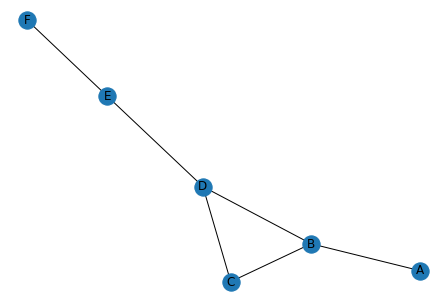

['D', 'C', 'D', 'C', 'D', 'B'] - [0, 1, 0, 1, 0, 2]
['A', 'B', 'C', 'D', 'B', 'A'] - [0, 1, 2, 3, 1, 0]
['A', 'B', 'D', 'E', 'D', 'C'] - [0, 1, 2, 3, 2, 4]
['D', 'E', 'F', 'E', 'F', 'E'] - [0, 1, 2, 1, 2, 1]
['F', 'E', 'D', 'E', 'F', 'E'] - [0, 1, 2, 1, 0, 1]


In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

G = nx.Graph()
G.add_nodes_from(['A','B','C','D','E','F'])
G.add_edges_from([
        ('A','B'), ('B','C'), ('B','D'),
        ('C','D'), ('D','E'), ('E','F')
    ])


nx.draw(G, with_labels=True)
plt.show()

for _ in range(5):
    w = generate_walks(G, walk_len=5)
    an_w = convert_walk(w)
    print(f"{w} - {an_w}")

## Anonymous Walk Embeddings
![](figures/03-nodeemb_57.jpeg)
![](figures/03-nodeemb_58.jpeg)
![](figures/03-nodeemb_59.jpeg)
![](figures/03-nodeemb_60.jpeg)
![](figures/03-nodeemb_61.jpeg)
![](figures/03-nodeemb_62.jpeg)
![](figures/03-nodeemb_63.jpeg)

In [33]:
import networkx as nx
import numpy as np
import torch
from torch import Tensor
import torch.nn.functional as F

from torch_geometric.datasets import TUDataset
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt

In [76]:
mutag = TUDataset(root="../datasets", name="MUTAG")

atom_labels = {
    0: "C", 1: "N", 2: "O", 3: "F",
    4: "I",  5: "Cl", 6: "Br"
    }

bond_labels = {
    0: "aromatic", 1: "single", 2: "double", 3: "triple"
   }

In [77]:
def mutag_plot(data):
    g = to_networkx(data, to_undirected=True)
    node_labels = {idx: atom_labels[atom] for idx, atom  in enumerate(data.x.argmax(1).tolist())}
    edge_labels = data.edge_attr.argmax(1).tolist()
    edge_labels = { (a, b): edge_labels[i] for i, (a, b) in enumerate(data.edge_index.t().tolist()) if a<b }
    
    pos = nx.spring_layout(g)
    nx.draw(g, pos=pos, labels=node_labels)
    nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=edge_labels)
    
    plt.show()

In [93]:
def get_graph(data, graph_id):
    """ convert MUTAG graph to networkx graphs
    """
    g = to_networkx(data, to_undirected=True)

    for idx, atom  in enumerate(data.x.argmax(1).tolist()):
        g.nodes[idx]['atom'] = atom
    edge_labels = data.edge_attr.argmax(1).tolist()
    for idx, (a, b) in enumerate(data.edge_index.t().tolist()):
        if a < b:
            g.edges[a, b]['bond'] = edge_labels[idx]
    g.graph['id'] = graph_id
    g.graph['label'] = data.y.tolist()[0]
    return g

In [91]:
def convert_walk(random_walks):
    annoymous_walk = []
    label_map = {}
    idx = 0
    for node in random_walks:
        if not node in label_map:
            label_map[node] = idx
            idx += 1
        annoymous_walk.append(label_map[node])
    return annoymous_walk 


def generate_random_walk(G, source_node, step_size):
    '''Creates anonymous walk from a node for arbitrary steps with usage of edge and node labels.
    Returns a tuple with consequent nodes and edges.'''
    node_idx = 0
    edge_idx = 0
    pattern = [0]
    node_labels = dict()
    edge_labels = dict()
    for _ in range(step_size):
        target_node = np.random.choice(list(G.neighbors(source_node)))
        node_label = G.nodes[source_node]['atom']
        edge_label = int(G.edges[source_node, target_node]['bond'])
        if node_label not in node_labels:
            node_labels[node_label] = node_idx
            node_idx += 1
        if edge_label not in edge_labels:
            edge_labels[edge_label] = edge_idx
            edge_idx += 1
        pattern.append(node_labels[node_label])
        pattern.append(edge_labels[edge_label])
        source_node = target_node
    return tuple(pattern)


def get_batch(g, batch_size=32, step_size=10):
    source_nodes = list(g.nodes)
    rws = [generate_random_walk(g, np.random.choice(source_nodes), step_size)  for _ in range(batch_size)]
    graph_ids = [g.graph['id']  for _ in range(batch_size)]
    labels = tuple(g.graph['label'] for _ in range(batch_size))
    return rws, labels